# Testing for Cointegration and Stationarity

### Imports

Please make sure to pandas 1.3.5 (pip3 install pandas==1.3.5)

In [38]:
# API to be used
import yfinance as yf
# principal data manipulation tools
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# data visualization
import seaborn as sns

# math
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS # least squares
from statsmodels.tsa.stattools import adfuller # augmented dicky fuller test
from statsmodels.tsa.stattools import coint # cointegration (not corrrelation)
from sklearn.model_selection import train_test_split
import datetime

# GUI
from ipywidgets import widgets, interact
from IPython.display import display

# magic
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Add securities below one at a time

In [39]:
ticker_list = []

add_ticker = widgets.Text(
    value = '',
    placeholder = 'Type a valid Ticker',
    description = 'Ticker name:',
    continuous_update = True
)

display(add_ticker)


def callback(widget):
    ticker_list.append(widget.value)
    
add_ticker.on_submit(callback)

# TODO: functionality for multiple securities entered at the same time
def multiple_securities():
    return

Text(value='', description='Ticker name:', placeholder='Type a valid Ticker')

In [40]:
# make sure the list is updating correctly
print(f'List: {ticker_list}')
print()
print(f'List size: {len(ticker_list)}')

List: []

List size: 0


In [41]:
# sample list 
ticker_list = ['IHF', 'XLU','XLP', 'SPY', 'XLE', 'XLY', 'XLK']
# ticker_list = ['AAPL', 'MSFT', 'FB', 'BOX', 'U', 'CRM', 'TWTR', 'SNAP', 'AMD', 'SQ', 'ABNB', 'PLTR', 'AMZN', 'TSLA', 'ROKU', 'NVDA', 'GOOG', 'NFLX', 'UBER', 'LYFT']

In [42]:
# scratch
ticker = yf.Ticker(ticker_list[0])
today = datetime.datetime.today()
hist = ticker.history(start = '2020-01-01', end = today)
hist = hist['Close']
hist[0]

196.6693878173828

### DataFrame set up

In [43]:
# preserve API calls when running this cell 
my_dict = {}
today = datetime.datetime.today()
# create a dictionary with all of the tickers as keys and all of the values in the form [Date, Close]
for i in range(len(ticker_list)):
    ticker = yf.Ticker(ticker_list[i])
#     about two years of data
    hist = ticker.history(start = '2020-01-01', end = today)
#     iterate over the hist data
    for j in range(len(hist)):
        my_dict[ticker_list[i]] = hist['Close']

In [44]:
df = pd.DataFrame(my_dict, index=hist['Close'].index)
# drop NaN values, which will mess with the statistics
df.dropna(inplace=True)

### Visualizing the Correlation Matrix

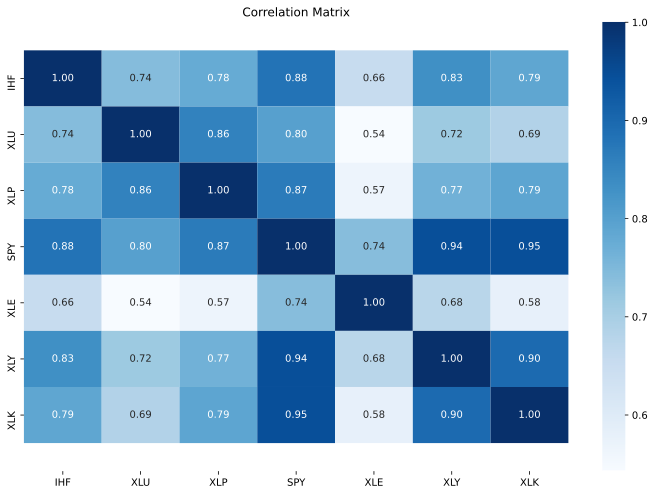

In [45]:
train, test = train_test_split(df, test_size = 0.5, shuffle = False)
fig, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(train.pct_change().corr(method = 'pearson'), ax = ax, annot = True, fmt = '.2f', cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Correlation Matrix')  
plt.tight_layout()

### Visualizing Cointegration (p-values)

In [46]:
# strong evidence against the null hypothesis
strict_pvalue = 0.01
# weak evidence against the null hypothesis
loose_pvalue = 0.07 

def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.02:
                pairs.append((keys[i], keys[j]))

    return pvalue_matrix, pairs

pvalues, pairs = find_cointegrated_pairs(df)
# these are the pairs in which 
print(pairs)

[('XLU', 'XLE')]


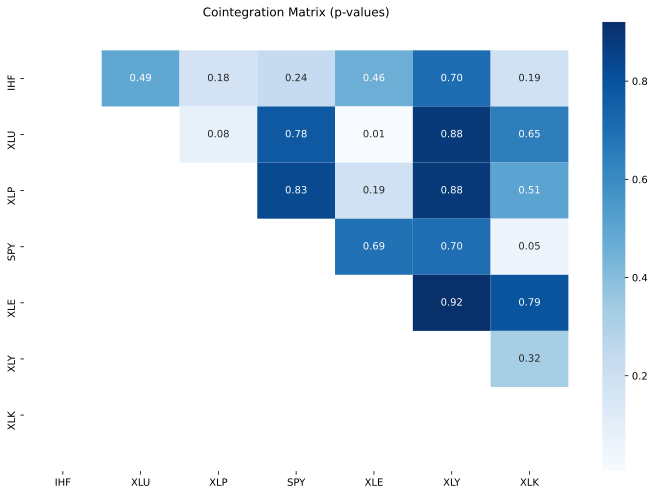

In [47]:
# print heatmap
fig, ax = plt.subplots(figsize=(10,7)) 
sns.heatmap(pvalues, xticklabels = train.columns, yticklabels = train.columns, annot = True, fmt = '.2f', mask = (pvalues >= 0.99), ax = ax, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Cointegration Matrix (p-values)')
plt.tight_layout()

### Plotting

In [48]:
# these two tickers are what need to be changed to use the tool for different securities

# TODO: implement widget to easily edit this infomration
ticker_1 = yf.Ticker('MSFT').info['symbol']
ticker_2 = yf.Ticker('AMZN').info['symbol']

KeyError: 'MSFT'

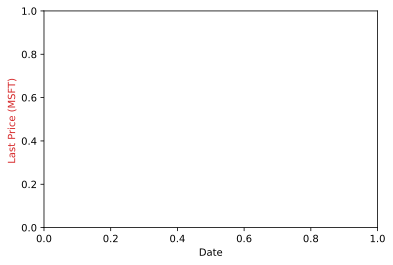

In [49]:
# Code edited from matplotlib documentaton: 
# https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/two_scales.html

fig, ax1 = plt.subplots()

# FORMATTING: ticker 1 data
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Last Price ({ticker_1}) ', color = color)
ax1.plot(train[ticker_1], color = color)
ax1.tick_params(axis = 'y', labelcolor = color, rotation = 45)

ax2 = ax1.twinx() 

# FORMATTING: ticker 2 data
color = 'tab:blue'
ax2.set_ylabel(f'Last Price ({ticker_2}) ', color = color)  # we already handled the x-label with ax1
ax2.plot(train[ticker_2], color = color)
ax2.tick_params(axis = 'y', labelcolor = color, rotation = 45)

# FORMATTING: rotate Dates
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.figsize = (10, 7)
plt.grid(True)

### Statistics and Spread

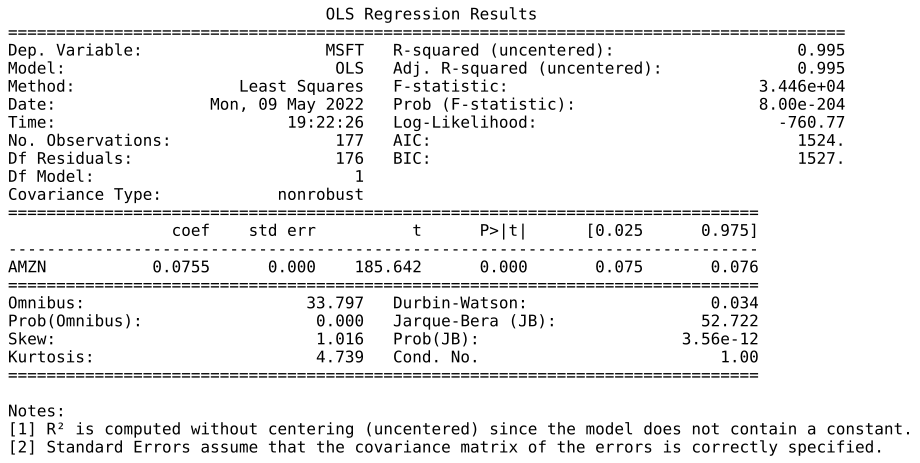

In [ ]:
# OLS regression
reg = sm.OLS(train[ticker_1], train[ticker_2]).fit()

plt.rc('figure', figsize = (10, 7))
plt.text(0.01, 0.05, str(reg.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left = 0.2, right = 0.3, top = 0.2, bottom = 0.1)

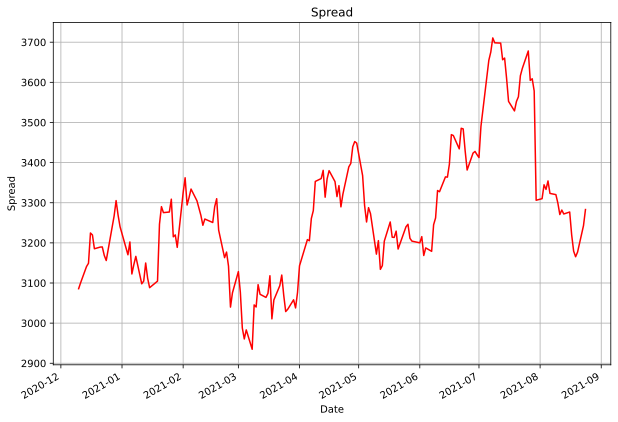

In [ ]:
# spread plot
spread = train[ticker_2] - reg.params[0] * train[ticker_1]
plot = spread.plot(title = 'Spread', color = 'r', ylabel = 'Spread')
plot.grid(True)

The mean of the ratios over this period is 0.07352643445053927


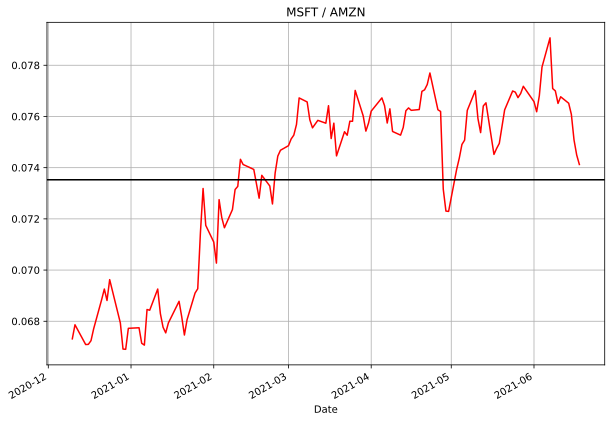

In [ ]:
ratio = train[ticker_1] / train[ticker_2]
n = len(ratio)
sum = 0 

for i in range(n):
    sum += ratio[i]
print (f'The mean of the ratios over this period is {sum / n}')

ratio.plot(title = f'{ticker_1} / {ticker_2}', color = 'r')
plt.axhline(ratio.mean(), color = 'black')
plt.grid(True)

In [ ]:
# Everything from here below is from https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916 

In [ ]:
# using widgets

# widgets.IntSlider(
#     min = 0,
#     max = len(ticker_dict) - 1,
#     step = 1,
#     description = 'Slider:',
#     value = 0
# )

# slider = widgets.IntSlider()
# display(slider)

In [ ]:
# linking two widgets
slider = widgets.IntSlider()
text = widgets.IntText()
display(slider, text)
widgets.jslink((slider, 'value'), (text, 'value'))
slider.keys

IntSlider(value=0)

IntText(value=0)

['_dom_classes',
 '_model_module',
 '_model_module_version',
 '_model_name',
 '_view_count',
 '_view_module',
 '_view_module_version',
 '_view_name',
 'continuous_update',
 'description',
 'description_tooltip',
 'disabled',
 'layout',
 'max',
 'min',
 'orientation',
 'readout',
 'readout_format',
 'step',
 'style',
 'value']

In [ ]:
print(dir(widgets))

['Accordion', 'AppLayout', 'Audio', 'BoundedFloatText', 'BoundedIntText', 'Box', 'Button', 'ButtonStyle', 'CallbackDispatcher', 'Checkbox', 'Color', 'ColorPicker', 'Combobox', 'Controller', 'CoreWidget', 'DOMWidget', 'DatePicker', 'Datetime', 'Dropdown', 'FileUpload', 'FloatLogSlider', 'FloatProgress', 'FloatRangeSlider', 'FloatSlider', 'FloatText', 'GridBox', 'GridspecLayout', 'HBox', 'HTML', 'HTMLMath', 'Image', 'IntProgress', 'IntRangeSlider', 'IntSlider', 'IntText', 'Label', 'Layout', 'NumberFormat', 'Output', 'Password', 'Play', 'RadioButtons', 'Select', 'SelectMultiple', 'SelectionRangeSlider', 'SelectionSlider', 'SliderStyle', 'Style', 'Tab', 'Text', 'Textarea', 'ToggleButton', 'ToggleButtons', 'ToggleButtonsStyle', 'TwoByTwoLayout', 'VBox', 'Valid', 'ValueWidget', 'Video', 'Widget', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'docutils', 'domwidget', 'fixed', 'interact', 'interact_manual', 'interaction', 

In [ ]:
# widget events
btn = widgets.Button(description='Medium')
display(btn)
def btn_eventhandler(obj):
    print(ticker_dict[0].format(obj.description))
btn.on_click(btn_eventhandler)

Button(description='Medium', style=ButtonStyle())